In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import sys
from pathlib import Path

from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, matthews_corrcoef
from sklearn.model_selection import train_test_split

# Dummy model

In [2]:
data = '../data/cgcnn_junwen_july_3_kdist/id_prop.csv'

In [3]:
df=pd.read_csv(data,header=None)

In [4]:
df.head(3)

,0,1
0,0,0.162055
1,1,0.467803
2,2,0.269011


In [5]:
train_ind, test_ind = train_test_split(df.index.values, test_size=0.1, random_state=456)

In [6]:
ytrain=df.iloc[train_ind][1].values

In [7]:
from sklearn.linear_model import QuantileRegressor

# quantile < 0.5 penalizes underestimation more
q = 0.1  # You can tune this
model = QuantileRegressor(quantile=q, alpha=0, fit_intercept=True)
X_dummy = np.ones((len(ytrain), 1)) # dummy feature, constant model
model.fit(X_dummy, ytrain)
ypred=model.predict(X_dummy)

c_opt = ypred[0]
c_opt

np.float64(0.1948101922617551)

In [8]:
ypred=model.predict(X_dummy)
ypred[0]

np.float64(0.1948101922617551)

# RF, Composition+structure+soap features

In [9]:
output_file = "../output/RF/RF_basic.csv"

In [10]:
df=pd.read_csv(output_file)

In [11]:
df.head(3)

,Unnamed: 0,ids,truth,pred,pred_std
0,0,2678,0.381003,0.437783,0.110292
1,1,3919,0.247393,0.224898,0.042050
2,2,828,0.545084,0.533213,0.083760


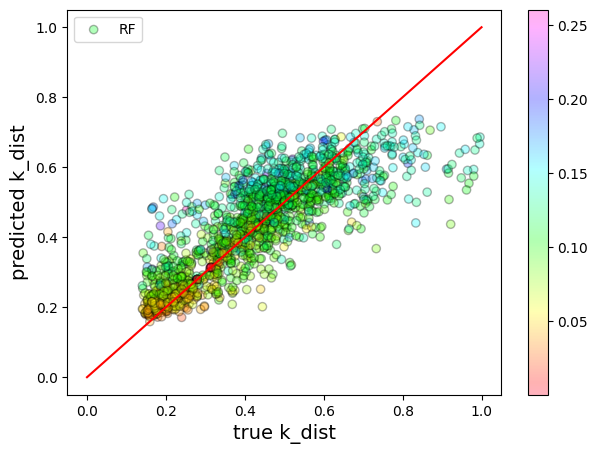

In [12]:
plt.figure(figsize=(7,5))
sc=plt.scatter(df['truth'].values, df['pred'].values, c=df['pred_std'].values,cmap='gist_rainbow', edgecolor='k', alpha=0.3, label='RF')
cbar = plt.colorbar(sc)
plt.plot([0,1],[0,1], color='red')
plt.xlabel('true k_dist', fontsize =14)
plt.ylabel('predicted k_dist', fontsize = 14)
plt.legend()
plt.show()

In [13]:
mse = mean_squared_error(df['truth'].values, df['pred'].values)
mae = mean_absolute_error(df['truth'].values, df['pred'].values)
mape = mean_absolute_percentage_error(df['truth'].values, df['pred'].values)
r2 = r2_score(df['truth'].values, df['pred'].values)
        
print(f'Test set MAE: {mae}')
print(f'Test set MAPE: {mape}')
print(f'Test set MSE: {mse}')
print(f'Test set R2 score: {r2}')

Test set MAE: 0.06847110025671213
Test set MAPE: 0.182577347513091
Test set MSE: 0.009264562376333182
Test set R2 score: 0.6967279321208621


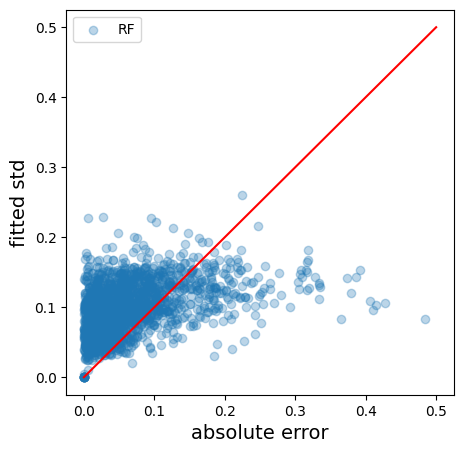

In [14]:
abs_errors=np.abs(df['truth'].values - df['pred'].values)

plt.figure(figsize=(5,5))
sc=plt.scatter(abs_errors, df['pred_std'].values, alpha=0.3, label='RF')
plt.plot([0,0.5],[0,0.5], color='red')
plt.xlabel('absolute error', fontsize =14)
plt.ylabel('fitted std', fontsize = 14)
plt.legend()
plt.show()

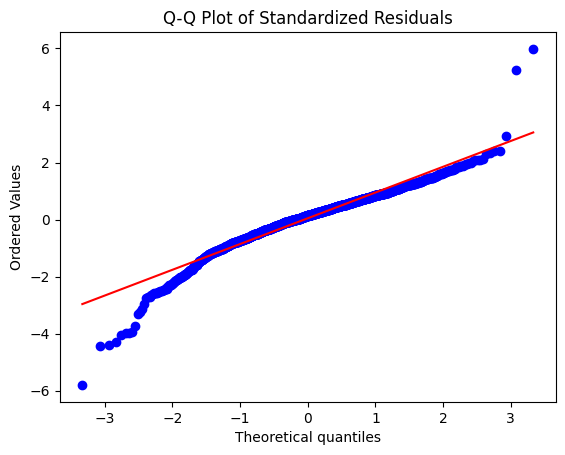

In [16]:
import scipy.stats as stats
import matplotlib.pyplot as plt

standardized_residuals = (df['pred'].values - df['truth'].values) / df['pred_std'].values
stats.probplot(standardized_residuals, dist="norm", plot=plt)
plt.title("Q-Q Plot of Standardized Residuals")
plt.show()

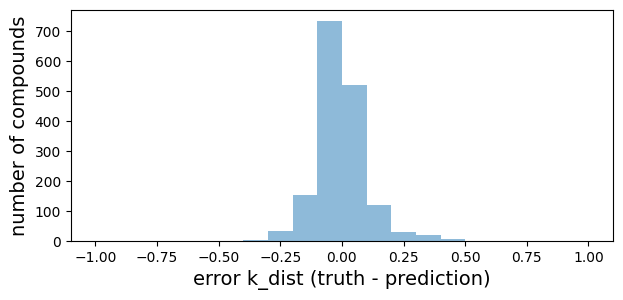

In [17]:
errors=df['truth'].values - df['pred'].values

plt.figure(figsize=(7,3))
plt.hist(errors, range=(-1,1), bins=20, alpha=0.5)
plt.xlabel('error k_dist (truth - prediction)', fontsize=14)
plt.ylabel('number of compounds', fontsize=14)
plt.show()

In [18]:
shifted_predictions=[]
for i in range(len(df)):
    value=stats.norm.interval(0.9, loc=df['pred'].values[i], scale=df['pred_std'].values[i])[0]
    if(value<0.02):
        shifted_predictions.append(0.02)
    else:
        shifted_predictions.append(value)

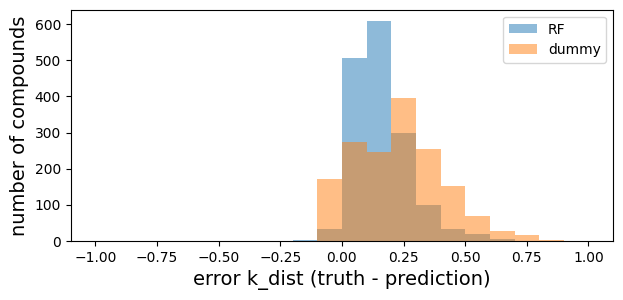

In [25]:
shifted_errors=df['truth'].values - shifted_predictions
dummy_errors=df['truth'].values-c_opt
neg_dummy = [x for x in dummy_errors if x < 0]
neg_errors=[x for x in shifted_errors if x < 0]

plt.figure(figsize=(7,3))
plt.hist(shifted_errors, range=(-1,1), bins=20, alpha=0.5, label = 'RF')
plt.hist(dummy_errors, range=(-1,1), bins=20, alpha=0.5, label = 'dummy')
plt.xlabel('error k_dist (truth - prediction)', fontsize=14)
plt.ylabel('number of compounds', fontsize=14)
plt.legend()
plt.show()

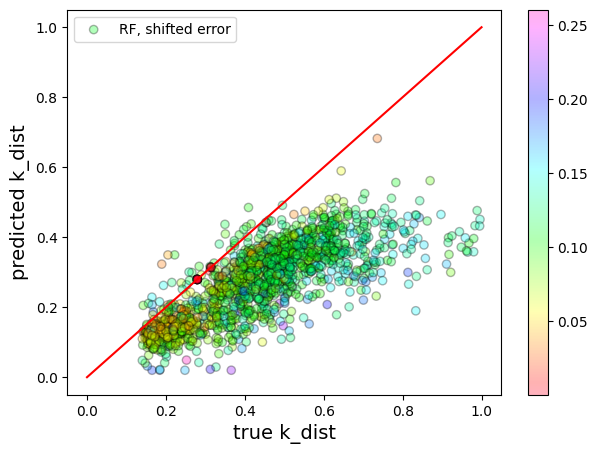

In [20]:
plt.figure(figsize=(7,5))
sc=plt.scatter(df['truth'].values, shifted_predictions, c=df['pred_std'].values,cmap='gist_rainbow', edgecolor='k', alpha=0.3, label='RF, shifted error')
cbar = plt.colorbar(sc)
plt.plot([0,1],[0,1], color='red')
plt.xlabel('true k_dist', fontsize =14)
plt.ylabel('predicted k_dist', fontsize = 14)
plt.legend()
plt.show()

In [21]:
np.sum([shifted_errors<0]), np.sum([shifted_errors<0])/len(shifted_errors), np.sum([dummy_errors<0]), np.sum([dummy_errors<0])/len(dummy_errors)

(np.int64(35),
 np.float64(0.02175264139216905),
 np.int64(171),
 np.float64(0.10627719080174021))

In [22]:
np.mean(neg_errors), np.mean(neg_dummy), len(neg_dummy)

(np.float64(-0.03991051592943436), np.float64(-0.023390659758869795), 171)

In [23]:
mse = mean_squared_error(df['truth'].values, shifted_predictions)
mae = mean_absolute_error(df['truth'].values, shifted_predictions)
mape = mean_absolute_percentage_error(df['truth'].values, shifted_predictions)
r2 = r2_score(df['truth'].values, shifted_predictions)
        
print(f'Test set MAE: {mae}')
print(f'Test set MAPE: {mape}')
print(f'Test set MSE: {mse}')
print(f'Test set R2 score: {r2}')

Test set MAE: 0.1595576786999685
Test set MAPE: 0.3619557053065588
Test set MSE: 0.03719059820974961
Test set R2 score: -0.2174206580491489


In [24]:
mse = mean_squared_error(df['truth'].values, c_opt*np.ones(len(df['truth'].values)))
mae = mean_absolute_error(df['truth'].values, c_opt*np.ones(len(df['truth'].values)))
mape = mean_absolute_percentage_error(df['truth'].values, c_opt*np.ones(len(df['truth'].values)))
r2 = r2_score(df['truth'].values, c_opt*np.ones(len(df['truth'].values)))
        
print(f'Test set MAE: {mae}')
print(f'Test set MAPE: {mape}')
print(f'Test set MSE: {mse}')
print(f'Test set R2 score: {r2}')

Test set MAE: 0.2333979632339724
Test set MAPE: 0.46945146824019546
Test set MSE: 0.0827272012573131
Test set R2 score: -1.708044738222041


# RF, Composition+structure+soap features, 'quantile regression'

In [34]:
output_file = "../output/RF/RF_basic_quantile_10.csv"

In [35]:
df=pd.read_csv(output_file)

In [36]:
df.head(3)

,Unnamed: 0,ids,truth,pred
0,0,2678,0.381003,0.349071
1,1,3919,0.247393,0.200781
2,2,828,0.545084,0.419215


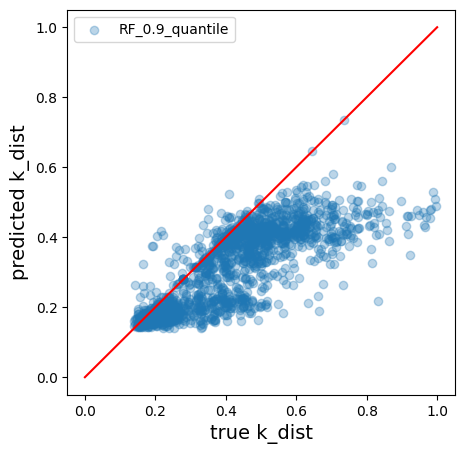

In [37]:
plt.figure(figsize=(5,5))
sc=plt.scatter(df['truth'].values, df['pred'].values, alpha=0.3, label='RF_0.9_quantile')
plt.plot([0,1],[0,1], color='red')
plt.xlabel('true k_dist', fontsize =14)
plt.ylabel('predicted k_dist', fontsize = 14)
plt.legend()
plt.show()

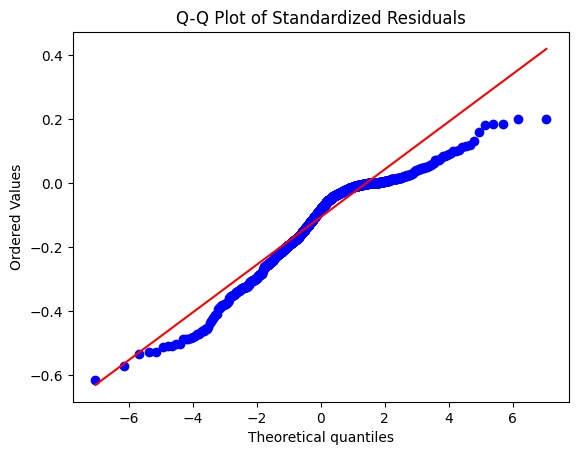

In [38]:
import scipy.stats as stats
import matplotlib.pyplot as plt

residuals = (df['pred'].values - df['truth'].values) 
stats.probplot(residuals, dist="laplace", plot=plt)
plt.title("Q-Q Plot of Standardized Residuals")
plt.show()

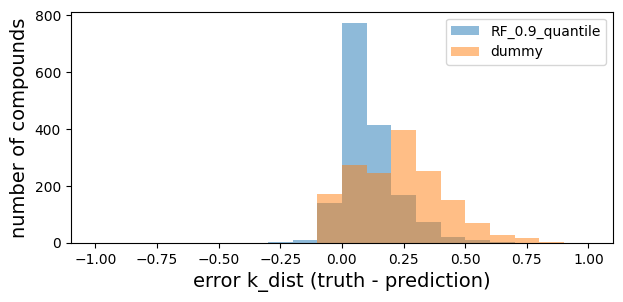

In [40]:
shifted_errors=df['truth'].values - df['pred'].values
dummy_errors=df['truth'].values-c_opt
neg_errors=[x for x in shifted_errors if x < 0]

plt.figure(figsize=(7,3))
plt.hist(shifted_errors, range=(-1,1), bins=20, alpha=0.5, label = 'RF_0.9_quantile')
plt.hist(dummy_errors, range=(-1,1), bins=20, alpha=0.5,label='dummy')
plt.xlabel('error k_dist (truth - prediction)', fontsize=14)
plt.ylabel('number of compounds', fontsize=14)
plt.legend()
plt.show()

In [65]:
np.sum([shifted_errors<0]), np.sum([shifted_errors<0])/len(shifted_errors), np.sum([dummy_errors<0]), np.sum([dummy_errors<0])/len(dummy_errors)

(np.int64(150),
 np.float64(0.09322560596643878),
 np.int64(173),
 np.float64(0.10752019888129273))

In [66]:
np.mean(neg_errors)

np.float64(-0.03149912939332258)

In [67]:
mse = mean_squared_error(df['truth'].values, df['pred'].values)
mae = mean_absolute_error(df['truth'].values, df['pred'].values)
mape = mean_absolute_percentage_error(df['truth'].values, df['pred'].values)
r2 = r2_score(df['truth'].values, df['pred'].values)
        
print(f'Test set MAE: {mae}')
print(f'Test set MAPE: {mape}')
print(f'Test set MSE: {mse}')
print(f'Test set R2 score: {r2}')

Test set MAE: 0.11160949206245387
Test set MAPE: 0.2363175359199388
Test set MSE: 0.023111982183257197
Test set R2 score: 0.24343769896702028


In [68]:
mse = mean_squared_error(df['truth'].values, c_opt*np.ones(len(df['truth'].values)))
mae = mean_absolute_error(df['truth'].values, c_opt*np.ones(len(df['truth'].values)))
mape = mean_absolute_percentage_error(df['truth'].values, c_opt*np.ones(len(df['truth'].values)))
r2 = r2_score(df['truth'].values, c_opt*np.ones(len(df['truth'].values)))
        
print(f'Test set MAE: {mae}')
print(f'Test set MAPE: {mape}')
print(f'Test set MSE: {mse}')
print(f'Test set R2 score: {r2}')

Test set MAE: 0.2328592259624145
Test set MAPE: 0.4683373118942666
Test set MSE: 0.08241461507945567
Test set R2 score: -1.6978123437819725


# GB, Composition+structure+soap features, quantile = 0.1

In [47]:
output_file = "../output/GB/GB_basic_quantile_10.csv"

In [48]:
df=pd.read_csv(output_file)

In [49]:
df.head(3)

,Unnamed: 0,ids,truth,pred
0,0,2678,0.381003,0.336212
1,1,3919,0.247393,0.164435
2,2,828,0.545084,0.400813


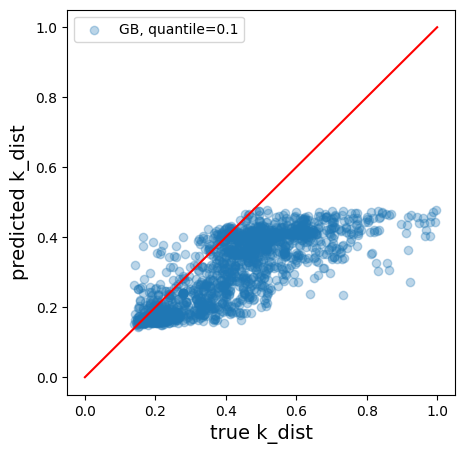

In [51]:
plt.figure(figsize=(5,5))
sc=plt.scatter(df['truth'].values, df['pred'].values, alpha=0.3, label='GB, quantile=0.1')
plt.plot([0,1],[0,1], color='red')
plt.xlabel('true k_dist', fontsize =14)
plt.ylabel('predicted k_dist', fontsize = 14)
plt.legend()
plt.show()

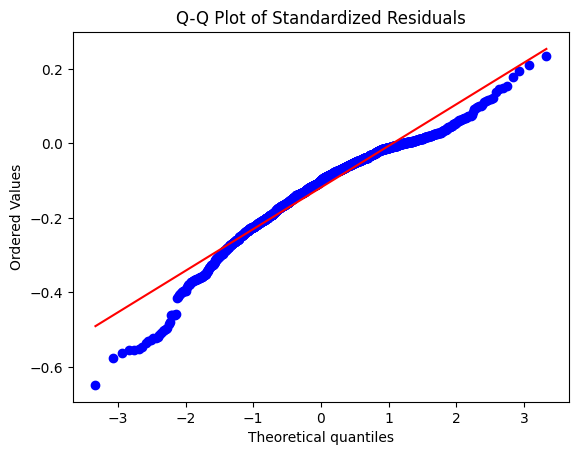

In [50]:
import scipy.stats as stats
import matplotlib.pyplot as plt

residuals = (df['pred'].values - df['truth'].values) 
stats.probplot(residuals, dist="norm", plot=plt)
plt.title("Q-Q Plot of Standardized Residuals")
plt.show()

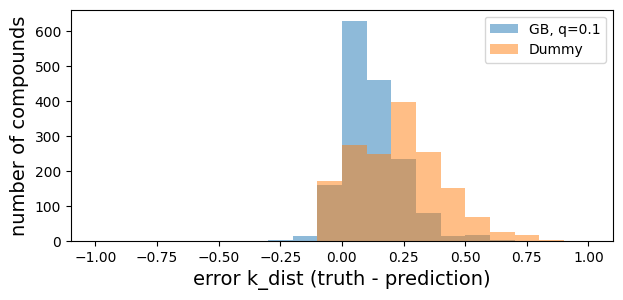

In [52]:
shifted_errors=df['truth'].values - df['pred'].values
dummy_errors=df['truth'].values-c_opt
neg_errors=[x for x in shifted_errors if x < 0]

plt.figure(figsize=(7,3))
plt.hist(shifted_errors, range=(-1,1), bins=20, alpha=0.5, label='GB, q=0.1')
plt.hist(dummy_errors, range=(-1,1), bins=20, alpha=0.5, label='Dummy')
plt.xlabel('error k_dist (truth - prediction)', fontsize=14)
plt.ylabel('number of compounds', fontsize=14)
plt.legend()
plt.show()

In [52]:
np.sum([shifted_errors<0]), np.sum([shifted_errors<0])/len(shifted_errors), np.sum([dummy_errors<0]), np.sum([dummy_errors<0])/len(dummy_errors)

(np.int64(175),
 np.float64(0.10876320696084525),
 np.int64(173),
 np.float64(0.10752019888129273))

In [54]:
np.mean(neg_errors)

np.float64(-0.03513863428029115)

In [55]:
mse = mean_squared_error(df['truth'].values, df['pred'].values)
mae = mean_absolute_error(df['truth'].values, df['pred'].values)
mape = mean_absolute_percentage_error(df['truth'].values, df['pred'].values)
r2 = r2_score(df['truth'].values, df['pred'].values)
        
print(f'Test set MAE: {mae}')
print(f'Test set MAPE: {mape}')
print(f'Test set MSE: {mse}')
print(f'Test set R2 score: {r2}')

Test set MAE: 0.12630437137437286
Test set MAPE: 0.26812431815685733
Test set MSE: 0.027130984513026386
Test set R2 score: 0.11187712461395705


In [56]:
mse = mean_squared_error(df['truth'].values, c_opt*np.ones(len(df['truth'].values)))
mae = mean_absolute_error(df['truth'].values, c_opt*np.ones(len(df['truth'].values)))
mape = mean_absolute_percentage_error(df['truth'].values, c_opt*np.ones(len(df['truth'].values)))
r2 = r2_score(df['truth'].values, c_opt*np.ones(len(df['truth'].values)))
        
print(f'Test set MAE: {mae}')
print(f'Test set MAPE: {mape}')
print(f'Test set MSE: {mse}')
print(f'Test set R2 score: {r2}')

Test set MAE: 0.2328592259624145
Test set MAPE: 0.4683373118942666
Test set MSE: 0.08241461507945567
Test set R2 score: -1.6978123437819725


# Comparison of RF and GB predictions

In [125]:
output_file = "../output/RF/RF_basic.csv"
output_file1 = "../output/GB/GB_basic.csv"

In [126]:
df=pd.read_csv(output_file)
df1=pd.read_csv(output_file1)

In [128]:
df['pred_gb']=df1['pred']

In [131]:
df['mean']=(df['pred_gb']+df['pred'])/2

In [132]:
df

,Unnamed: 0,ids,truth,pred,pred_std,pred_gb,mean
0,0,2678,0.381003,0.437783,0.110292,0.437030,0.437406
1,1,3919,0.247393,0.224898,0.042050,0.230313,0.227605
2,2,828,0.545084,0.533213,0.083760,0.499511,0.516362
3,3,10972,0.168094,0.486169,0.182073,0.419224,0.452696
4,4,15974,0.404552,0.405313,0.090722,0.307929,0.356621
...,...,...,...,...,...,...,...
1604,1604,15906,0.343143,0.354925,0.040089,0.287913,0.321419
1605,1605,11631,0.218668,0.215616,0.048743,0.229962,0.222789
1606,1606,11977,0.801816,0.677538,0.156268,0.651580,0.664559
1607,1607,15816,0.353187,0.388413,0.080341,0.381124,0.384768


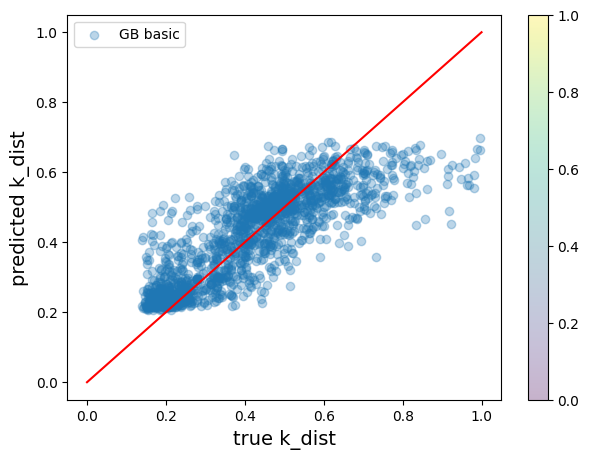

In [136]:
plt.figure(figsize=(7,5))
sc=plt.scatter(df1['truth'].values, df1['pred'].values, alpha=0.3, label='GB basic')
cbar = plt.colorbar(sc)
plt.plot([0,1],[0,1], color='red')
plt.xlabel('true k_dist', fontsize =14)
plt.ylabel('predicted k_dist', fontsize = 14)
plt.legend()
plt.show()

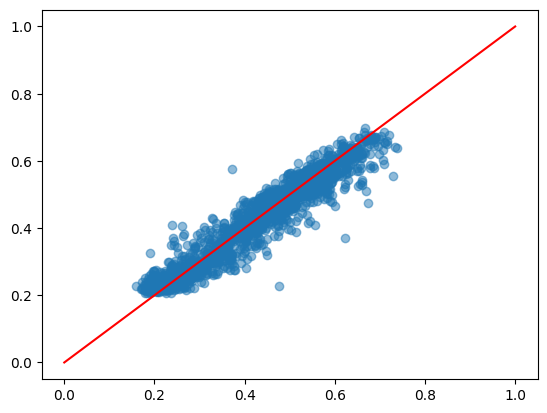

In [130]:
plt.scatter(df['pred'], df['pred_gb'], alpha=0.5)
plt.plot([0,1],[0,1], color='red')
plt.show()

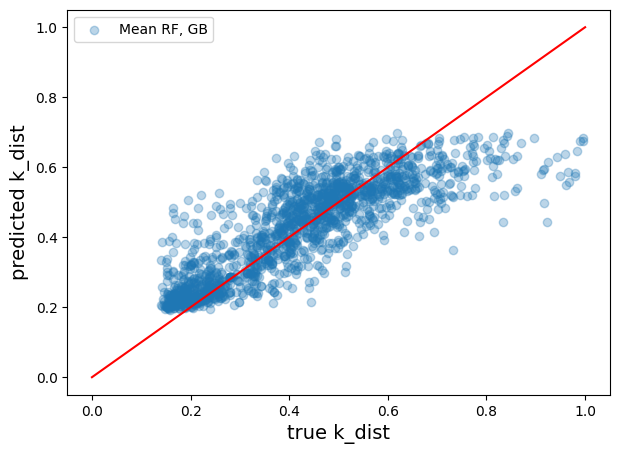

In [138]:
plt.figure(figsize=(7,5))
sc=plt.scatter(df['truth'].values, df['mean'].values, alpha=0.3, label='Mean RF, GB')
plt.plot([0,1],[0,1], color='red')
plt.xlabel('true k_dist', fontsize =14)
plt.ylabel('predicted k_dist', fontsize = 14)
plt.legend()
plt.show()

In [139]:
mse = mean_squared_error(df['truth'].values, df['mean'].values)
mae = mean_absolute_error(df['truth'].values, df['mean'].values)
mape = mean_absolute_percentage_error(df['truth'].values, df['mean'].values)
r2 = r2_score(df['truth'].values, df['mean'].values)
        
print(f'Test set MAE: {mae}')
print(f'Test set MAPE: {mape}')
print(f'Test set MSE: {mse}')
print(f'Test set R2 score: {r2}')

Test set MAE: 0.07127882576016885
Test set MAPE: 0.19230676023728716
Test set MSE: 0.009518587373908621
Test set R2 score: 0.6884125165428423
